# More advanced image classification

In this notebook we will try out some more fancy variations of convolutional networks. First we try training from scratch, then we will have a look at _fine-tuning_ pre-trainined models.

In [1]:
import os
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

2026-01-11 16:46:10.679477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768146370.839553   46650 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768146370.883201   46650 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-11 16:46:11.369251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the data

For this task we will do binary classification of images containing either cats or dogs.
The data are available on Kaggle (as a 786MB zip archive):

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  65.2M      0  0:00:12  0:00:12 --:--:-- 67.0M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls


 01_digit_classification.ipynb		  PetImages
 02_fashion_MNIST_classification.ipynb	  README.md
 03_advanced_image_classification.ipynb   assets
 1_digit_classification.ipynb		  kagglecatsanddogs_5340.zip
 2_fashion_MNIST_classification.ipynb	 'readme[1].txt'
 CDLA-Permissive-2.0.pdf


Here you should see a folder named `PetImages`, which contains two subfolders: `Cat` and `Dog`.
Occationaly we will come across data which is corrupted or otherwise broken, so let's go through all the files and delete those with broken headers.

In [4]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")


Deleted 1558 images.


Since out data are now a set of files rather than an array of numbers, we have to do an extra step compared to the previous notebooks. Luckily, `keras.utils` contains various convenience functions to help us out. The code below creates TensorFlow `Dataset`s ([`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)), which will lazy-load the image files once they are needed during training.

The documentation for the `image_dataset_from_directory` function can be found [here](https://keras.io/api/data_loading/image/).

In [5]:
image_shape = (180, 180, 3)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_shape[:2],
    batch_size=batch_size,
)


Found 23442 files belonging to 2 classes.
Using 18754 files for training.
Using 4688 files for validation.


W0000 00:00:1768146524.820385   46650 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Let's visualise the first few images:

2026-01-11 16:48:45.248088: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


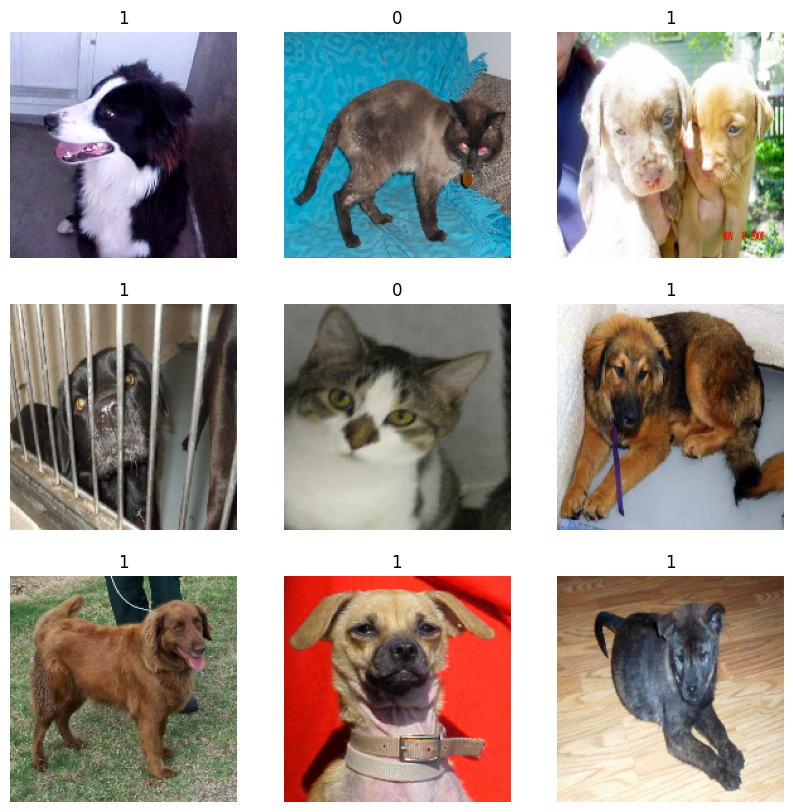

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Artificially increase the dataset size by _augmentation_

If we rotate an image of a cat by 45 degrees, is it still an image of a cat? We know the answer is yes, but to your neural network, it might not be that obvious. We will now try to improve generalisation by dynamically adding small modifications to the data, which preserves the information of each image but alters the pixel values.

In [7]:
data_augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),      # Randomly flip (mirror) horizontally
    keras.layers.RandomRotation(0.1),           # Add a random rotation
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


Pick a single image and apply the augmentation nine times:

2026-01-11 16:48:46.450982: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


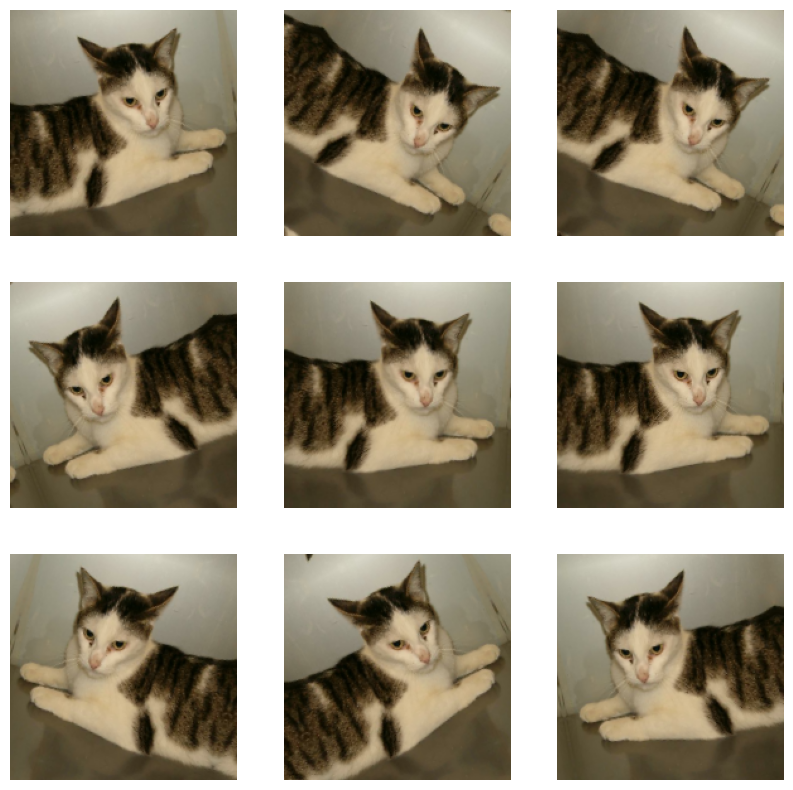

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


### <span style="color: red;">Exercise:<span>
Change the arguments in the data augmentation (like replace "horizontal" with "vertical") and see how the images change. Add new types of augmentation by looking at the relevant [Keras documentation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/).

To apply the augmentation during training, there are two options. The first and the simplest is to make it part of the model -- notice that our `data_augmentation` function contains Keras layers, after all. The second option is to manipulate the TensorFlow `Dataset` objects. We will do the latter, to get some experience with doing so.

Apply the augmentation to each image by using the `map` function, which behaves like Python's `map`, but is parallelised.

In [9]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

Notice the use of `tf.data.AUTOTUNE`, which will set number of parallel jobs to be optimal for our system. Magic!

Now another magic trick: Tell TensorFlow to prefetch images and put them in GPU memory, which speeds up things.

In [10]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Build a simple model

With the technicalities of data processing in place, we can now build a convolutional network. We start with the sequential model API, which we know already.

In [11]:
sequential_model = keras.Sequential(
    [
        keras.Input(shape=image_shape),
        keras.layers.Rescaling(1.0/255),    # Standardise the images on-the-fly
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

We can visualise the model, with layer shapes and all, using `plot_model`.  

In [12]:
keras.utils.plot_model(sequential_model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


#### The functional model API

Towards the end of the notebook we will try out models that have complicated layer connections. In this case, the sequential way of building a model (like above) is a too limiting, and we need to work with the _functional_ API.

As the name says, we will treat each layer of the network as a function, which operates on the output of a different layer. The code following code defines a model identical to the one above. Just to avoid having too many global variables floating around, let's get used to defining our models in a function.

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Rescaling(1.0 / 255)(inputs)
    x = keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.4)(x)
    outputs = keras.layers.Dense(num_classes, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

functional_model = make_model(image_shape, 1)

Verify that this model does in fact look like the sequential model from before:

In [14]:
keras.utils.plot_model(functional_model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Training the model

Even though we had to do some tricks to the data loading, the training step works with TensorFlow datasets without much fuss.

However, since we are now using considerably more data than last time (both bigger images, and a lot more images), training will start to take some time.

In [ ]:
epochs = 5

functional_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss="binary_crossentropy",             # notice we use binary_crossentropy (not categorical_crossentropy)
    metrics=["accuracy"],
)
functional_model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/5


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 17/147 ━━━━━━━━━━━━━━━━━━━━ 3:02 1s/step - accuracy: 0.4736 - loss: 0.7621

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 18/147 ━━━━━━━━━━━━━━━━━━━━ 3:00 1s/step - accuracy: 0.4744 - loss: 0.7603

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 37/147 ━━━━━━━━━━━━━━━━━━━━ 2:32 1s/step - accuracy: 0.4826 - loss: 0.7379

 60/147 ━━━━━━━━━━━━━━━━━━━━ 1:59 1s/step - accuracy: 0.4950 - loss: 0.7238

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 68/147 ━━━━━━━━━━━━━━━━━━━━ 1:48 1s/step - accuracy: 0.4996 - loss: 0.7201

Now we can test the model on a single image:

In [ ]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_shape[:2])
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = functional_model.predict(img_array)
score = predictions[0][0]
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")


### <span style="color: red;">Exercise:<span>
Update the `make_model` function to create a new and improved model using the functional API, which has an additional `Conv2D` layer, followed by a `MaxPooling2D` layer. Remember to insert these at meaningful places in the model!

Then train and try out the model like we did above.

### Build a complicated model

The code below showcases how the functional API can be used to create non-sequential models with arbitrary connections between layers, using a small version of the [Xception](https://arxiv.org/abs/1610.02357) architecture as an example.

This model uses layers and techniques you haven't seen yet, so you are absolutely not expected to understand everything, but it's fun to get to play with the more advanced stuff.

In [ ]:
def make_xception_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = keras.layers.Rescaling(1.0 / 255)(inputs)
    x = keras.layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = keras.layers.Dropout(0.25)(x)

    outputs = keras.layers.Dense(units, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


xception_model = make_xception_model(input_shape=image_shape, num_classes=1)
keras.utils.plot_model(xception_model, show_shapes=True)


### <span style="color: red;">Optional:<span>

Train the network defined above.

### Fine-tuning existing models

Often we want to solve a rather specific problem (like classifying images of cats and dogs), and we already have access to an existing model that solves a similar or more general problem (like classifying images of other things). In this case it can be very efficient to use the existing model, but change the last layer -- the classification layer -- while keeping the knowledge in the convolutional layers in front. Then we only need to train the last layer (or potentially the couple of last layers), which is known as _fine-tuning_.

Loads of high-performing computer vision models are available in [Keras Applications](https://keras.io/api/applications/). Let's pick the full-scale version of the Xception network, and download the pre-trained version _without_ the final classification layer.

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=image_shape,
    include_top=False
)

Some technicalities are required when putting together out new model, and these are most likely dependent on the type of pre-trained model we use. Remember to read the documentation! In this case, the relevant docs are listed [here](https://keras.io/api/applications/xception/).

First thing is to preprocess the images according to what the model requires.

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (keras.applications.xception.preprocess_input(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

Now we add our new classification layer on top of the pre-trained Xception model, which we will call our `base_model`. An important thing to note here is that we want to keep the existing convolutional layers unmodified -- this is done by setting `training=False` in `base_model`.

In [ ]:
# Specify how the input images look
inputs = keras.Input(shape=(image_shape))

# Create the base model, with fixed parameters
x = base_model(inputs, training=False)

# Convert the output from the last convolutional layers into an array
x = keras.layers.GlobalAveragePooling2D()(x)

# Add the final classification layer
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

# Piece it all together into the final model
model = keras.Model(inputs, outputs)

Now let's train the final model on our own data. This is relatively fast since we only need to optimise the parameters of the single classification layer. We say "relatively" because the cost of computing the forward pass of a big model is still the same, but training time until convergence is a lot less.

In [ ]:
epochs = 5

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Do a performance test on the image from before:

In [ ]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_shape[:2])
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis
img_array = keras.applications.xception.preprocess_input(img_array)

predictions = model.predict(img_array)
score = predictions[0][0]
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

### <span style="color: red;">Exercise:<span>

Try out fine-tuning different models available in Keras, in particular [ResNet50](https://keras.io/api/applications/resnet/#resnet50v2-function) and [EfficientNetB0](https://keras.io/api/applications/efficientnet/#efficientnetb0-function). If you are feeling adventurous, try one of the bigger ones, like those in the [ConvNeXt](https://keras.io/api/applications/convnext/#convnextbase-function) family (but be aware the memory requirements of these ones).

Read more about fine-tuning in Keras here: [Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/)